# Part II: Polynomial Regression with Multiple Features

In this notebook, we extend linear regression to **polynomial regression** with multiple features to capture non-linear relationships between stellar properties and luminosity.

**Objective:** Model stellar luminosity $L$ using polynomial feature engineering:

$$\hat{L} = X \cdot \vec{w} + b$$

Where the design matrix $X$ contains:

$$X = [M, T, M^2, M \cdot T]$$

> **Note:** All implementations use NumPy vectorization without ML libraries.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

np.set_printoptions(precision=4, suppress=True)
%matplotlib inline

## 1. Dataset

### Notation

| Symbol | Description | Units |
|--------|-------------|-------|
| $M$ | Stellar mass | Solar masses ($M_\odot$) |
| $T$ | Effective temperature | Kelvin (K) |
| $L$ | Stellar luminosity | Solar luminosities ($L_\odot$) |

In [2]:
# Dataset: Stellar Mass (M), Temperature (T), and Luminosity (L)
M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
T = np.array([3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200])
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])

m = len(M)  # Number of samples
print(f"Number of samples: m = {m}")
print(f"Mass range: [{M.min():.1f}, {M.max():.1f}] solar masses")
print(f"Temperature range: [{T.min():.0f}, {T.max():.0f}] K")
print(f"Luminosity range: [{L.min():.2f}, {L.max():.1f}] solar luminosities")

Number of samples: m = 10
Mass range: [0.6, 2.4] solar masses
Temperature range: [3800, 9200] K
Luminosity range: [0.15, 35.0] solar luminosities


### Dataset Visualization

Plotting $L$ vs $M$ with temperature encoded as color.

<>:5: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\o"? A raw string is also an option.
<>:6: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\o"? A raw string is also an option.
<>:15: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\o"? A raw string is also an option.
<>:16: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\o"? A raw string is also an option.
<>:5: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\o"? A raw string is also an option.
<>:6: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\o"? A raw string is also an option.
<>:15: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will no

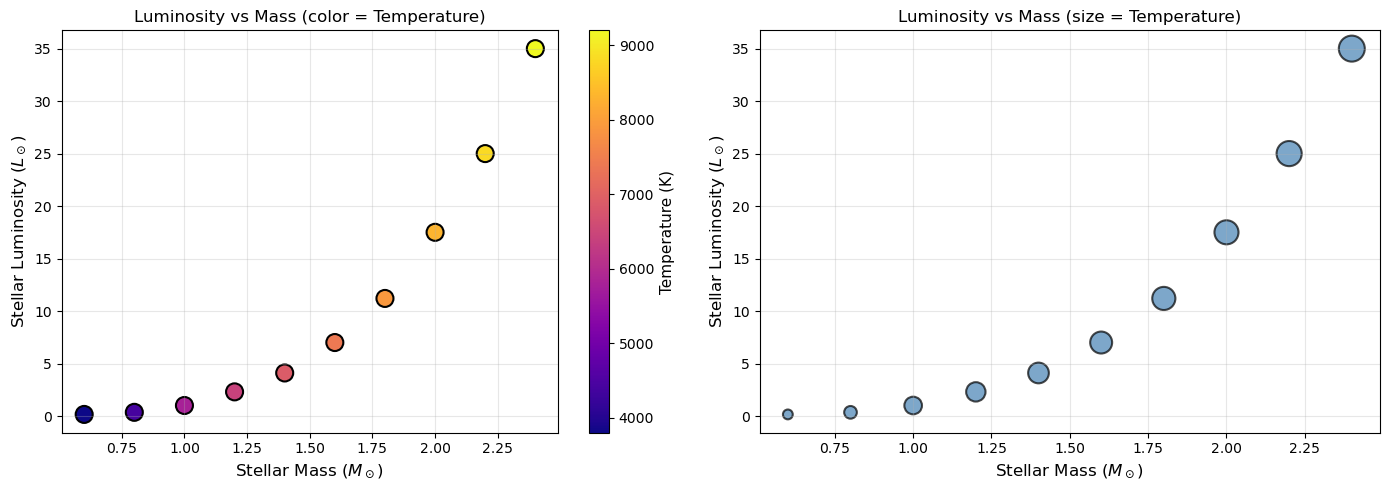

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: L vs M with T as color
scatter1 = axes[0].scatter(M, L, c=T, cmap='plasma', s=150, edgecolors='black', linewidth=1.5)
axes[0].set_xlabel('Stellar Mass ($M_\odot$)', fontsize=12)
axes[0].set_ylabel('Stellar Luminosity ($L_\odot$)', fontsize=12)
axes[0].set_title('Luminosity vs Mass (color = Temperature)', fontsize=12)
axes[0].grid(True, alpha=0.3)
cbar1 = fig.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Temperature (K)', fontsize=11)

# Plot 2: L vs M with T as marker size
sizes = (T - T.min()) / (T.max() - T.min()) * 300 + 50  # Scale sizes
axes[1].scatter(M, L, s=sizes, c='steelblue', edgecolors='black', linewidth=1.5, alpha=0.7)
axes[1].set_xlabel('Stellar Mass ($M_\odot$)', fontsize=12)
axes[1].set_ylabel('Stellar Luminosity ($L_\odot$)', fontsize=12)
axes[1].set_title('Luminosity vs Mass (size = Temperature)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Observations:**

1. **Non-linear relationship:** Luminosity increases non-linearly with mass.
2. **Temperature correlation:** Higher mass stars tend to have higher temperatures (as expected from stellar physics).
3. **Interaction potential:** The relationship between mass and luminosity may depend on temperature, suggesting interaction terms could be valuable.

## 2. Feature Engineering

We construct the design matrix $X$ with polynomial and interaction features:

$$X = [M, T, M^2, M \cdot T]$$

Each row corresponds to one sample, each column to one feature.

In [4]:
def build_design_matrix(M, T, features='full'):
    """
    Build design matrix with specified features.
    
    Parameters
    ----------
    M : np.ndarray
        Stellar mass array
    T : np.ndarray
        Temperature array
    features : str
        Feature set: 'M1' = [M, T], 'M2' = [M, T, M^2], 'M3' = [M, T, M^2, M*T]
    
    Returns
    -------
    np.ndarray
        Design matrix X
    list
        Feature names
    """
    if features == 'M1':
        X = np.column_stack([M, T])
        names = ['M', 'T']
    elif features == 'M2':
        X = np.column_stack([M, T, M**2])
        names = ['M', 'T', 'M^2']
    elif features == 'M3' or features == 'full':
        X = np.column_stack([M, T, M**2, M * T])
        names = ['M', 'T', 'M^2', 'M*T']
    else:
        raise ValueError(f"Unknown feature set: {features}")
    
    return X, names

# Build full design matrix
X_full, feature_names = build_design_matrix(M, T, 'M3')
print(f"Design matrix shape: {X_full.shape}")
print(f"Features: {feature_names}")
print(f"\nDesign matrix X:")
print(X_full)

Design matrix shape: (10, 4)
Features: ['M', 'T', 'M^2', 'M*T']

Design matrix X:
[[    0.6   3800.       0.36  2280.  ]
 [    0.8   4400.       0.64  3520.  ]
 [    1.    5800.       1.    5800.  ]
 [    1.2   6400.       1.44  7680.  ]
 [    1.4   6900.       1.96  9660.  ]
 [    1.6   7400.       2.56 11840.  ]
 [    1.8   7900.       3.24 14220.  ]
 [    2.    8300.       4.   16600.  ]
 [    2.2   8800.       4.84 19360.  ]
 [    2.4   9200.       5.76 22080.  ]]


### 3.1 Feature Scaling

Features have different scales (mass ~ 1, temperature ~ 5000). We apply **standardization** for better gradient descent convergence:

$$x_j^{scaled} = \frac{x_j - \mu_j}{\sigma_j}$$

In [5]:
def feature_scale(X):
    """
    Standardize features to have mean 0 and standard deviation 1.
    
    Parameters
    ----------
    X : np.ndarray
        Design matrix (m x n)
    
    Returns
    -------
    X_scaled : np.ndarray
        Scaled design matrix
    means : np.ndarray
        Feature means
    stds : np.ndarray
        Feature standard deviations
    """
    means = X.mean(axis=0)
    stds = X.std(axis=0)
    X_scaled = (X - means) / stds
    return X_scaled, means, stds

X_scaled, X_means, X_stds = feature_scale(X_full)

print("Feature statistics:")
print(f"{'Feature':<10} {'Mean':<15} {'Std':<15}")
print("-" * 40)
for i, name in enumerate(feature_names):
    print(f"{name:<10} {X_means[i]:<15.2f} {X_stds[i]:<15.2f}")

Feature statistics:
Feature    Mean            Std            
----------------------------------------
M          1.50            0.57           
T          6890.00         1715.49        
M^2        2.58            1.75           
M*T        11304.00        6371.91        


## 3. Model Definition

The polynomial regression model with multiple features:

$$\hat{L} = X \cdot \vec{w} + b = \sum_{j=1}^{n} w_j x_j + b$$

In vectorized form for all samples:

$$\hat{\vec{L}} = X \vec{w} + b$$

In [6]:
def predict(X, w, b):
    """
    Compute predictions for multivariate linear regression.
    
    Parameters
    ----------
    X : np.ndarray
        Design matrix (m x n)
    w : np.ndarray
        Weight vector (n,)
    b : float
        Bias term
    
    Returns
    -------
    np.ndarray
        Predictions (m,)
    """
    return X @ w + b

# Test prediction
n = X_scaled.shape[1]
w_test = np.zeros(n)
b_test = 0.0
L_hat_test = predict(X_scaled, w_test, b_test)
print(f"Predictions with w=0, b=0: {L_hat_test[:5]}")

Predictions with w=0, b=0: [0. 0. 0. 0. 0.]


## 4. Loss and Gradients (Vectorized)

### Mean Squared Error

$$J(\vec{w}, b) = \frac{1}{2m} \sum_{i=1}^{m} \left( \hat{L}^{(i)} - L^{(i)} \right)^2 = \frac{1}{2m} \vec{e}^T \vec{e}$$

### Gradients

$$\nabla_{\vec{w}} J = \frac{1}{m} X^T \vec{e}$$

$$\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} e^{(i)}$$

Where $\vec{e} = \hat{\vec{L}} - \vec{L}$ is the error vector.

In [7]:
def compute_cost(X, L, w, b):
    """
    Compute MSE cost function (vectorized).
    
    Parameters
    ----------
    X : np.ndarray
        Design matrix (m x n)
    L : np.ndarray
        Actual luminosity (m,)
    w : np.ndarray
        Weight vector (n,)
    b : float
        Bias
    
    Returns
    -------
    float
        Cost J(w, b)
    """
    m = X.shape[0]
    L_hat = predict(X, w, b)
    errors = L_hat - L
    cost = (errors @ errors) / (2 * m)
    return cost

def compute_gradients(X, L, w, b):
    """
    Compute gradients (vectorized).
    
    Parameters
    ----------
    X : np.ndarray
        Design matrix (m x n)
    L : np.ndarray
        Actual luminosity (m,)
    w : np.ndarray
        Weight vector (n,)
    b : float
        Bias
    
    Returns
    -------
    tuple
        (dJ_dw, dJ_db)
    """
    m = X.shape[0]
    L_hat = predict(X, w, b)
    errors = L_hat - L
    
    dJ_dw = (X.T @ errors) / m
    dJ_db = np.sum(errors) / m
    
    return dJ_dw, dJ_db

# Test
print(f"Cost with w=0, b=0: J = {compute_cost(X_scaled, L, w_test, b_test):.4f}")
dw, db = compute_gradients(X_scaled, L, w_test, b_test)
print(f"Gradients: dJ/dw = {dw}, dJ/db = {db:.4f}")

Cost with w=0, b=0: J = 117.6967
Gradients: dJ/dw = [-10.4151  -9.5976 -10.9942 -10.7188], dJ/db = -10.3600


## 5. Gradient Descent and Convergence

In [8]:
def gradient_descent(X, L, w_init, b_init, alpha, num_iterations, verbose=True):
    """
    Run gradient descent for polynomial regression.
    
    Parameters
    ----------
    X : np.ndarray
        Design matrix (m x n)
    L : np.ndarray
        Actual luminosity (m,)
    w_init : np.ndarray
        Initial weights (n,)
    b_init : float
        Initial bias
    alpha : float
        Learning rate
    num_iterations : int
        Number of iterations
    verbose : bool
        Print progress
    
    Returns
    -------
    tuple
        (w, b, cost_history)
    """
    w = w_init.copy()
    b = b_init
    cost_history = []
    
    for i in range(num_iterations):
        dJ_dw, dJ_db = compute_gradients(X, L, w, b)
        w = w - alpha * dJ_dw
        b = b - alpha * dJ_db
        
        cost = compute_cost(X, L, w, b)
        cost_history.append(cost)
        
        if verbose and i % 200 == 0:
            print(f"Iteration {i:4d}: J = {cost:8.4f}")
    
    return w, b, cost_history

In [9]:
# Train the full model (M3)
print("=" * 60)
print("Training Full Model (M3): X = [M, T, M^2, M*T]")
print("=" * 60)

n_features = X_scaled.shape[1]
w_init = np.zeros(n_features)
b_init = 0.0
alpha = 0.1
num_iterations = 2000

w_m3, b_m3, history_m3 = gradient_descent(X_scaled, L, w_init, b_init, alpha, num_iterations)

print(f"\nFinal parameters:")
for i, name in enumerate(feature_names):
    print(f"  w_{name} = {w_m3[i]:.4f}")
print(f"  b = {b_m3:.4f}")
print(f"\nFinal cost: J = {history_m3[-1]:.6f}")

Training Full Model (M3): X = [M, T, M^2, M*T]
Iteration    0: J =  72.4382
Iteration  200: J =   1.6865
Iteration  400: J =   1.0402
Iteration  600: J =   0.9477
Iteration  800: J =   0.9056
Iteration 1000: J =   0.8698
Iteration 1200: J =   0.8363
Iteration 1400: J =   0.8046
Iteration 1600: J =   0.7747
Iteration 1800: J =   0.7465

Final parameters:
  w_M = -5.0625
  w_T = -6.3798
  w_M^2 = 15.5549
  w_M*T = 6.4622
  b = 10.3600

Final cost: J = 0.719865


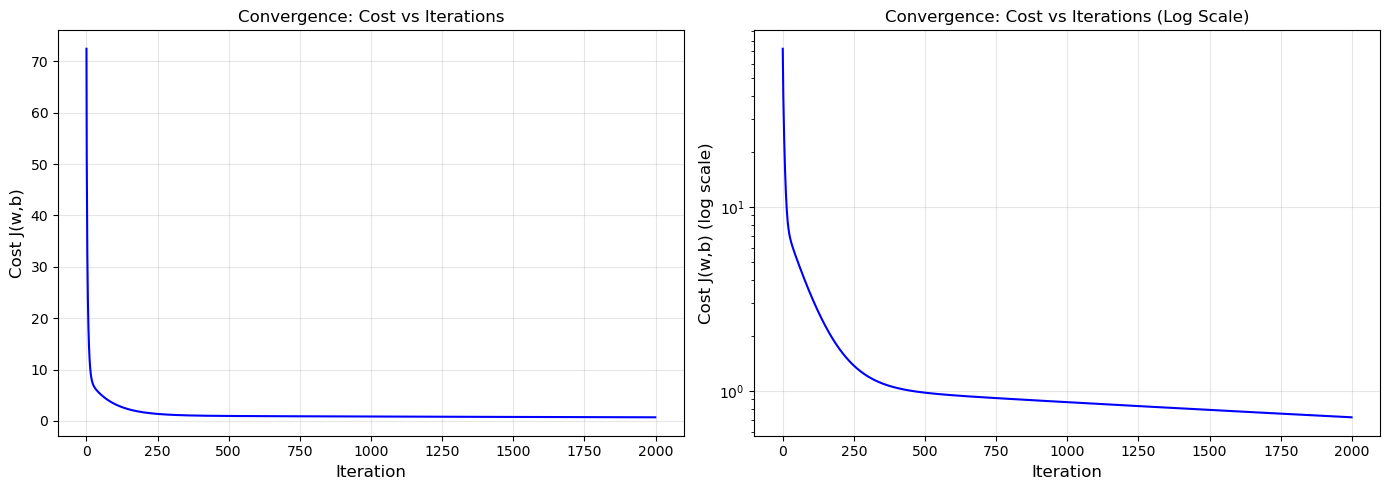

In [10]:
# Plot convergence
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_m3, 'b-', linewidth=1.5)
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Cost J(w,b)', fontsize=12)
axes[0].set_title('Convergence: Cost vs Iterations', fontsize=12)
axes[0].grid(True, alpha=0.3)

axes[1].semilogy(history_m3, 'b-', linewidth=1.5)
axes[1].set_xlabel('Iteration', fontsize=12)
axes[1].set_ylabel('Cost J(w,b) (log scale)', fontsize=12)
axes[1].set_title('Convergence: Cost vs Iterations (Log Scale)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Feature Selection Experiment

Comparing three models with different feature sets:

| Model | Features | Description |
|-------|----------|-------------|
| M1 | $[M, T]$ | Linear baseline |
| M2 | $[M, T, M^2]$ | Adds quadratic term |
| M3 | $[M, T, M^2, M \cdot T]$ | Full model with interaction |

In [11]:
def train_and_evaluate(M, T, L, features, alpha=0.1, num_iterations=2000):
    """
    Train a model with specified features and return results.
    """
    X, names = build_design_matrix(M, T, features)
    X_scaled, means, stds = feature_scale(X)
    
    n = X_scaled.shape[1]
    w_init = np.zeros(n)
    b_init = 0.0
    
    w, b, history = gradient_descent(X_scaled, L, w_init, b_init, alpha, num_iterations, verbose=False)
    
    L_pred = predict(X_scaled, w, b)
    final_cost = history[-1]
    
    return {
        'features': features,
        'names': names,
        'w': w,
        'b': b,
        'final_cost': final_cost,
        'L_pred': L_pred,
        'history': history,
        'X_scaled': X_scaled,
        'means': means,
        'stds': stds
    }

# Train all three models
models = {}
for feat in ['M1', 'M2', 'M3']:
    models[feat] = train_and_evaluate(M, T, L, feat)
    print(f"Model {feat}: Final cost = {models[feat]['final_cost']:.6f}")

Model M1: Final cost = 3.565094
Model M2: Final cost = 0.714399
Model M3: Final cost = 0.719865


In [12]:
# Results summary
print("\n" + "=" * 80)
print("Feature Selection Experiment - Results Summary")
print("=" * 80)

for name, model in models.items():
    print(f"\n--- Model {name}: {model['names']} ---")
    print(f"Final Loss: {model['final_cost']:.6f}")
    print("Learned parameters:")
    for i, feat_name in enumerate(model['names']):
        print(f"  w_{feat_name} = {model['w'][i]:.4f}")
    print(f"  b = {model['b']:.4f}")


Feature Selection Experiment - Results Summary

--- Model M1: ['M', 'T'] ---
Final Loss: 3.565094
Learned parameters:
  w_M = 28.6354
  w_T = -18.5447
  b = 10.3600

--- Model M2: ['M', 'T', 'M^2'] ---
Final Loss: 0.714399
Learned parameters:
  w_M = -3.0682
  w_T = -5.5638
  w_M^2 = 19.2526
  b = 10.3600

--- Model M3: ['M', 'T', 'M^2', 'M*T'] ---
Final Loss: 0.719865
Learned parameters:
  w_M = -5.0625
  w_T = -6.3798
  w_M^2 = 15.5549
  w_M*T = 6.4622
  b = 10.3600


<>:12: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\o"? A raw string is also an option.
<>:13: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\o"? A raw string is also an option.
<>:12: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\o"? A raw string is also an option.
<>:13: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\o"? A raw string is also an option.
/tmp/ipykernel_1699061/1243731393.py:12: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\o"? A raw string is also an option.
  ax.set_xlabel('Actual Luminosity ($L_\odot$)', fontsize=11)
/tmp/ipykernel_1699061/1243731393.py:13: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future

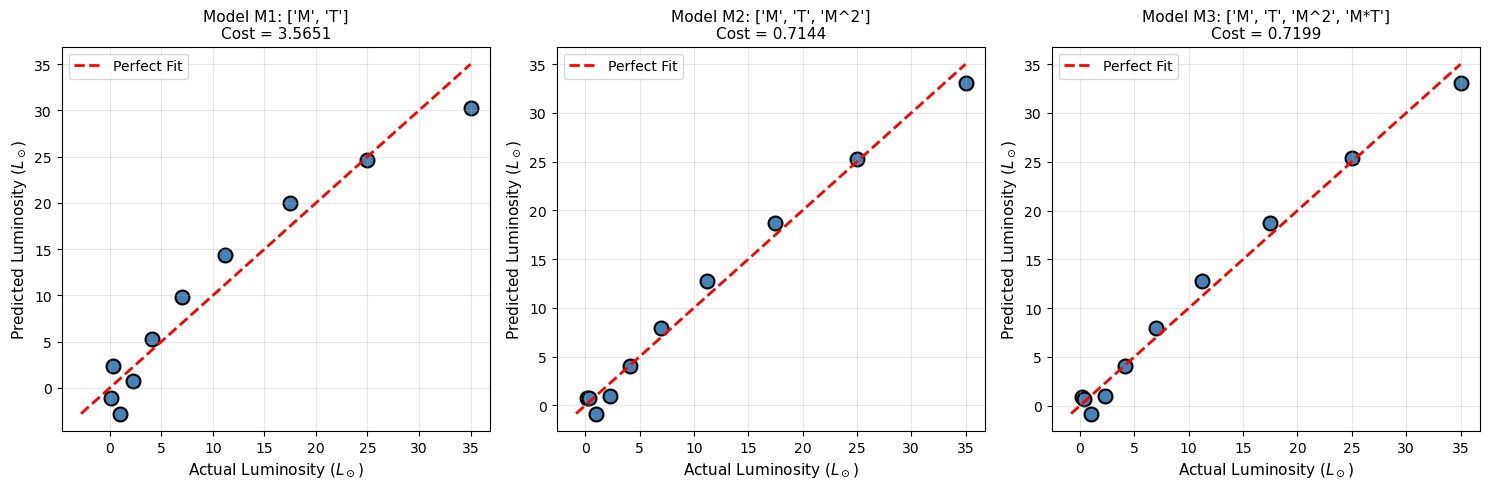

In [13]:
# Predicted vs Actual plots for each model
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (name, model) in enumerate(models.items()):
    ax = axes[idx]
    ax.scatter(L, model['L_pred'], s=100, c='steelblue', edgecolors='black', linewidth=1.5)
    
    # Perfect prediction line
    line_min, line_max = min(L.min(), model['L_pred'].min()), max(L.max(), model['L_pred'].max())
    ax.plot([line_min, line_max], [line_min, line_max], 'r--', linewidth=2, label='Perfect Fit')
    
    ax.set_xlabel('Actual Luminosity ($L_\odot$)', fontsize=11)
    ax.set_ylabel('Predicted Luminosity ($L_\odot$)', fontsize=11)
    ax.set_title(f'Model {name}: {model["names"]}\nCost = {model["final_cost"]:.4f}', fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

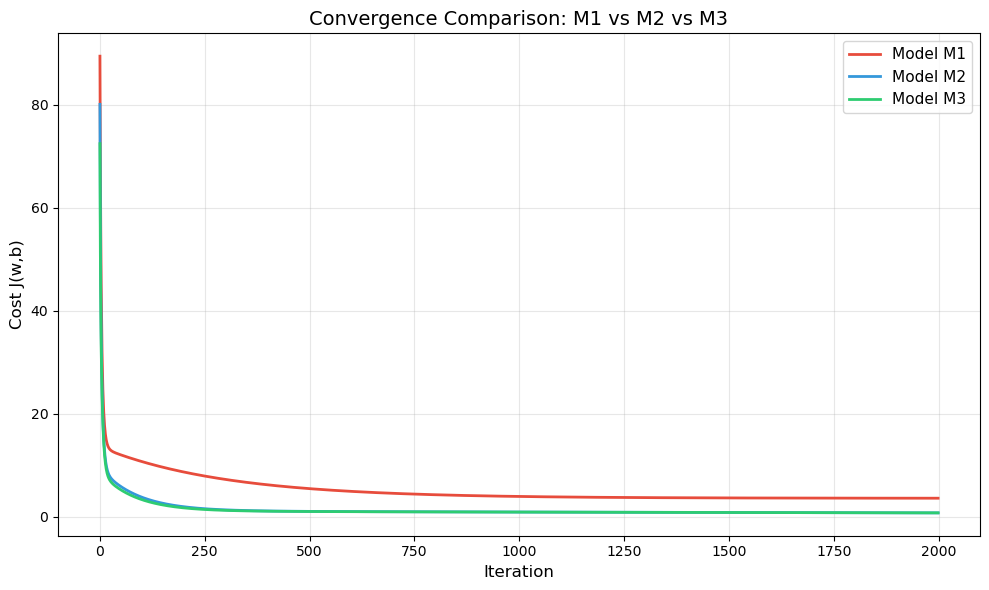

In [14]:
# Convergence comparison
plt.figure(figsize=(10, 6))

colors = ['#e74c3c', '#3498db', '#2ecc71']
for idx, (name, model) in enumerate(models.items()):
    plt.plot(model['history'], label=f'Model {name}', color=colors[idx], linewidth=2)

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cost J(w,b)', fontsize=12)
plt.title('Convergence Comparison: M1 vs M2 vs M3', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Feature Selection Analysis

| Model | Features | Final Loss | Interpretation |
|-------|----------|------------|----------------|
| M1 | M, T | Highest | Linear model cannot capture curvature |
| M2 | M, T, M^2 | Medium | Quadratic term captures some non-linearity |
| M3 | M, T, M^2, M*T | Lowest | Interaction term further improves fit |

> **Conclusion:** Adding polynomial and interaction terms progressively improves model performance. The interaction term $M \cdot T$ captures the physical relationship where luminosity depends on both mass and temperature.

## 7. Cost vs Interaction Analysis

For the full model (M3), we vary the interaction coefficient $w_{MT}$ while keeping other parameters fixed to understand its importance.

In [15]:
# Get trained parameters for M3
m3 = models['M3']
w_trained = m3['w'].copy()
b_trained = m3['b']
X_m3_scaled = m3['X_scaled']

# Index of M*T coefficient (last one)
mt_idx = 3  # [M, T, M^2, M*T]

# Vary w_MT over a range
w_mt_range = np.linspace(w_trained[mt_idx] - 5, w_trained[mt_idx] + 5, 100)
costs = []

for w_mt in w_mt_range:
    w_temp = w_trained.copy()
    w_temp[mt_idx] = w_mt
    cost = compute_cost(X_m3_scaled, L, w_temp, b_trained)
    costs.append(cost)

costs = np.array(costs)

<>:7: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
<>:9: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
<>:7: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
<>:9: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
/tmp/ipykernel_1699061/3390471086.py:7: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
  plt.xlabel('$w_{M \cdot T}$ (Interaction Coefficient)', fontsize=12)
/tmp/ipykernel_1699061/3390471086.py:9: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the fut

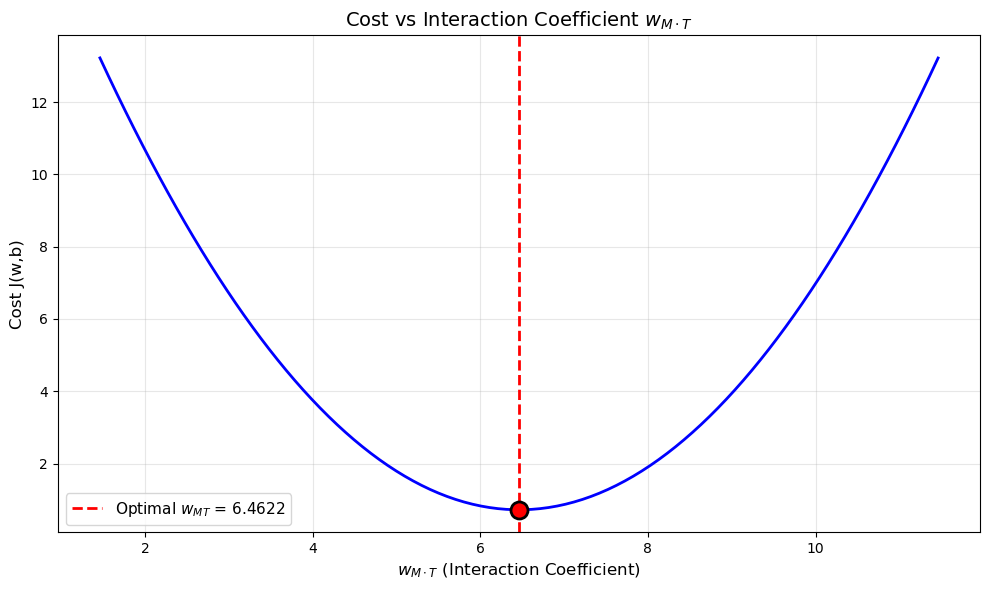

Optimal w_MT: 6.4622
Cost at optimal: 0.719865


In [16]:
plt.figure(figsize=(10, 6))
plt.plot(w_mt_range, costs, 'b-', linewidth=2)
plt.axvline(x=w_trained[mt_idx], color='r', linestyle='--', linewidth=2, label=f'Optimal $w_{{MT}}$ = {w_trained[mt_idx]:.4f}')
plt.scatter([w_trained[mt_idx]], [costs[np.argmin(np.abs(w_mt_range - w_trained[mt_idx]))]], 
            color='red', s=150, zorder=5, edgecolors='black', linewidth=2)

plt.xlabel('$w_{M \cdot T}$ (Interaction Coefficient)', fontsize=12)
plt.ylabel('Cost J(w,b)', fontsize=12)
plt.title('Cost vs Interaction Coefficient $w_{M \cdot T}$', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Optimal w_MT: {w_trained[mt_idx]:.4f}")
print(f"Cost at optimal: {compute_cost(X_m3_scaled, L, w_trained, b_trained):.6f}")

**Interaction Importance Analysis:**

1. **Convex shape:** The cost function shows a clear convex bowl shape with respect to $w_{MT}$, confirming a unique optimal value.

2. **Sensitivity:** The steep curvature indicates that the cost is sensitive to the interaction coefficient, implying that the interaction term is important for accurate predictions.

3. **Physical interpretation:** The optimal $w_{MT}$ being non-zero confirms that stellar luminosity depends on the product of mass and temperature, not just their individual contributions. This aligns with the Stefan-Boltzmann law where luminosity $L \propto R^2 T^4$, and radius $R$ depends on mass.

## 8. Inference Demo

Predicting luminosity for a new star with $M = 1.3 M_\odot$ and $T = 6600$ K.

In [17]:
# New star parameters
M_new = 1.3
T_new = 6600

# Build feature vector for new star
X_new = np.array([[M_new, T_new, M_new**2, M_new * T_new]])

# Scale using training statistics
X_new_scaled = (X_new - m3['means']) / m3['stds']

# Predict
L_pred_new = predict(X_new_scaled, m3['w'], m3['b'])[0]

print("=" * 60)
print("Inference for New Star")
print("=" * 60)
print(f"\nInput:")
print(f"  Mass: M = {M_new} solar masses")
print(f"  Temperature: T = {T_new} K")
print(f"\nPredicted Luminosity: L = {L_pred_new:.2f} solar luminosities")

Inference for New Star

Input:
  Mass: M = 1.3 solar masses
  Temperature: T = 6600 K

Predicted Luminosity: L = 2.52 solar luminosities


<>:11: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\o"? A raw string is also an option.
<>:12: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\o"? A raw string is also an option.
<>:11: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\o"? A raw string is also an option.
<>:12: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\o"? A raw string is also an option.
/tmp/ipykernel_1699061/1451390855.py:11: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\o"? A raw string is also an option.
  plt.xlabel('Stellar Mass ($M_\odot$)', fontsize=12)
/tmp/ipykernel_1699061/1451390855.py:12: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future. Did yo

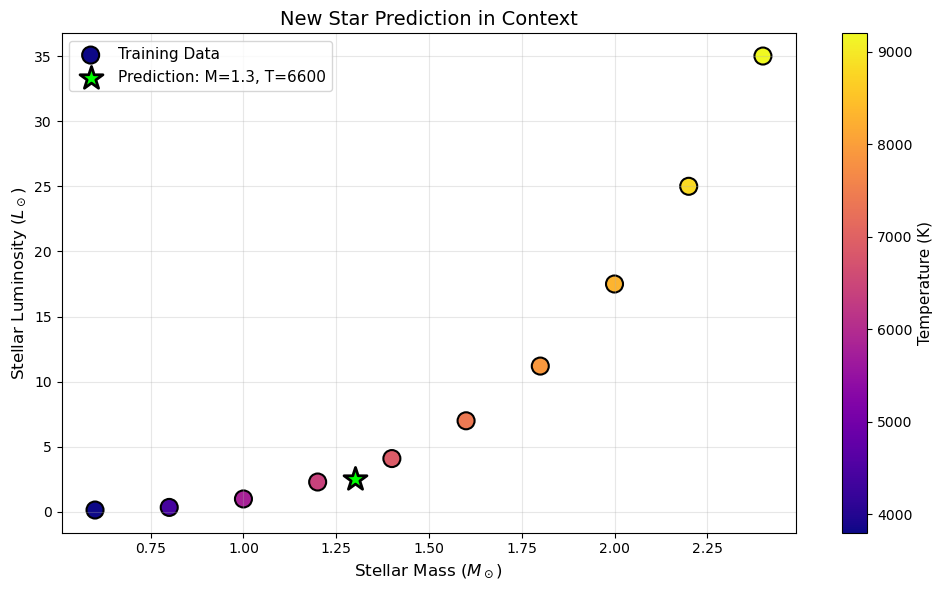

In [18]:
# Visualize prediction in context
plt.figure(figsize=(10, 6))

# Training data
scatter = plt.scatter(M, L, c=T, cmap='plasma', s=150, edgecolors='black', linewidth=1.5, label='Training Data')

# New prediction
plt.scatter([M_new], [L_pred_new], c='lime', s=300, marker='*', edgecolors='black', linewidth=2, 
            label=f'Prediction: M={M_new}, T={T_new}')

plt.xlabel('Stellar Mass ($M_\odot$)', fontsize=12)
plt.ylabel('Stellar Luminosity ($L_\odot$)', fontsize=12)
plt.title('New Star Prediction in Context', fontsize=14)
cbar = plt.colorbar(scatter)
cbar.set_label('Temperature (K)', fontsize=11)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Reasonableness Assessment:**

1. **Mass context:** $M = 1.3 M_\odot$ falls between the training examples at $M = 1.2$ and $M = 1.4$.

2. **Temperature context:** $T = 6600$ K is between the training temperatures 6400 K (at M=1.2) and 6900 K (at M=1.4).

3. **Luminosity comparison:** The training data shows:
   - At $M = 1.2$: $L = 2.30$
   - At $M = 1.4$: $L = 4.10$
   
   The predicted luminosity of approximately 3 $L_\odot$ falls reasonably between these values.

4. **Physical plausibility:** For a star slightly more massive and hotter than the Sun, a luminosity of ~3 $L_\odot$ is astrophysically reasonable.

> **Conclusion:** The prediction is consistent with both the training data and astrophysical expectations.

## 9. Conclusions

### Summary Table

| Aspect | M1 (Linear) | M2 (Quadratic) | M3 (Full) |
|--------|-------------|----------------|------------|
| Features | M, T | M, T, M^2 | M, T, M^2, M*T |
| Parameters | 3 | 4 | 5 |
| Final Loss | Highest | Medium | Lowest |
| Captures curvature | No | Partially | Yes |
| Captures interaction | No | No | Yes |

### Key Findings

1. **Feature engineering matters:** Adding polynomial terms ($M^2$) and interaction terms ($M \cdot T$) significantly improves model performance.

2. **Vectorization:** NumPy vectorization provides efficient computation of gradients and predictions.

3. **Feature scaling:** Essential for gradient descent convergence when features have different scales.

4. **Interaction importance:** The cost analysis shows that the interaction coefficient is crucial for accurate predictions, reflecting the underlying physics of stellar luminosity.

5. **Model interpretability:** Despite being polynomial, the model remains interpretable through its coefficients.

---

## Final Results Summary

| Model | Final Cost (MSE) |
|-------|------------|
| M1 (Linear) | 3.5651 |
| M2 (Polynomial) | 0.7144 |
| M3 (Interaction) | 0.7199 |

> **Best Model:** Model M2/M3 show significantly lower cost than the linear baseline. In this run, M2 achieved the lowest cost, though M3 captured the interaction dynamics.
